# GROUP-10

TEAM MEMBERS -
1. DHRUV GOEL(23110098)
2. NITIN BANSAL(23110223)

## Section 1

### Task 1

In [76]:
# Import the neccessary libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np

In [2]:
# Load the Iris dataset
df = load_iris()
x = df.data
y = df.target.reshape(-1, 1)

In [3]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output = False)
y_encoded = encoder.fit_transform(y)

In [4]:
# Split into train, validation and test sets in (70%, 10%, 20%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

In [5]:
# Find maximum and minimum of each column for scaling
max_column = x.max(axis = 0)
min_column = x.min(axis = 0)

In [6]:
# Normalize feature values to [0,1] using MinMaxScaler
x_train_scaled = np.zeros([x_train.shape[0],x_train.shape[1]])
x_val_scaled = np.zeros([x_val.shape[0],x_val.shape[1]])
x_test_scaled = np.zeros([x_test.shape[0],x_test.shape[1]])

for i in range(x_train.shape[0]):
  for j in range(4):
    x_train_scaled[i][j] =(x_train[i][j] - min_column[j]) / (max_column[j] - min_column[j])

for i in range(x_val.shape[0]):
  for j in range(4):
    x_val_scaled[i][j] = (x_val[i][j] - min_column[j]) / (max_column[j] - min_column[j])

for i in range(x_test.shape[0]):
  for j in range(4):
    x_test_scaled[i][j] = (x_test[i][j] - min_column[j]) / (max_column[j] - min_column[j])

### Task 2

In [7]:
# Importing required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# Define the neural network used in this
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)  # Hidden Layer
        self.fc2 = nn.Linear(16, 3)    # Output Layer

    def forward(self, x):
        # Activation function (ReLU)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Converting NumPy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Creating DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Task 4

In [10]:
!pip install wandb

In [32]:
# IMporting wandb
import wandb

In [33]:
# Initialize wandb
wandb.login()
wandb.init(project="STT_assignment_6", name="MLP-Training")

In [34]:
# Define Hyperparameters
epochs = 500
batch_size = 32
learning_rate = 0.001

# Initializing model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Log Model & Hyperparameters
wandb.config.update({
    "model_architecture": "MLP (4-16-3)",
    "hidden_layer_neurons": 16,
    "activation_function": "ReLU",
    "optimizer": "Adam",
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs
})

# Training the model
train_losses = []
val_losses = []
for epoch in range(1,epochs+1):
    model.train()
    total_train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Log to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    # Display results after every 5 epoches
    if (epoch % 5 ==0):
      print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Evaluate the model for test
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predicted = torch.argmax(outputs, dim=1)  # Get class index
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(torch.argmax(y_batch, dim=1).cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

Epoch 5/500, Train Loss: 1.1262, Val Loss: 1.1277
Epoch 10/500, Train Loss: 1.1047, Val Loss: 1.1024
Epoch 15/500, Train Loss: 1.0827, Val Loss: 1.0771
Epoch 20/500, Train Loss: 1.0607, Val Loss: 1.0491
Epoch 25/500, Train Loss: 1.0179, Val Loss: 1.0180
Epoch 30/500, Train Loss: 0.9841, Val Loss: 0.9824
Epoch 35/500, Train Loss: 0.9545, Val Loss: 0.9458
Epoch 40/500, Train Loss: 0.9121, Val Loss: 0.9082
Epoch 45/500, Train Loss: 0.8702, Val Loss: 0.8710
Epoch 50/500, Train Loss: 0.8234, Val Loss: 0.8332
Epoch 55/500, Train Loss: 0.7984, Val Loss: 0.7963
Epoch 60/500, Train Loss: 0.7565, Val Loss: 0.7610
Epoch 65/500, Train Loss: 0.7191, Val Loss: 0.7277
Epoch 70/500, Train Loss: 0.6912, Val Loss: 0.6966
Epoch 75/500, Train Loss: 0.6432, Val Loss: 0.6675
Epoch 80/500, Train Loss: 0.6460, Val Loss: 0.6409
Epoch 85/500, Train Loss: 0.5925, Val Loss: 0.6172
Epoch 90/500, Train Loss: 0.5906, Val Loss: 0.5956
Epoch 95/500, Train Loss: 0.5842, Val Loss: 0.5759
Epoch 100/500, Train Loss: 0.544

### Task 3

In [35]:
# Importing library for the metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Finding accuracy, precision, recall and f1 score for the model
accuracy_percentage=(accuracy_score(y_true,y_pred))*100
precision_percentage=(precision_score(y_true, y_pred, average="weighted"))*100
recall_percentage=(recall_score(y_true,y_pred, average="weighted"))*100
f1_percentage=(f1_score(y_true,y_pred, average="weighted"))*100

print("Stats:")
print(f"Accuracy: {accuracy_percentage:.2f}%")
print(f"Precision: {precision_percentage:.2f}%")
print(f"Recall: {recall_percentage:.2f}%")
print(f"F1 Score: {f1_percentage:.2f}%")

# Logging the metrics to the wandb
wandb.log({"Accuracy": accuracy_percentage/100})
wandb.log({"Precision": precision_percentage/100})
wandb.log({"Recall": recall_percentage/100})
wandb.log({"F1 score": f1_percentage/100})

Stats:
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


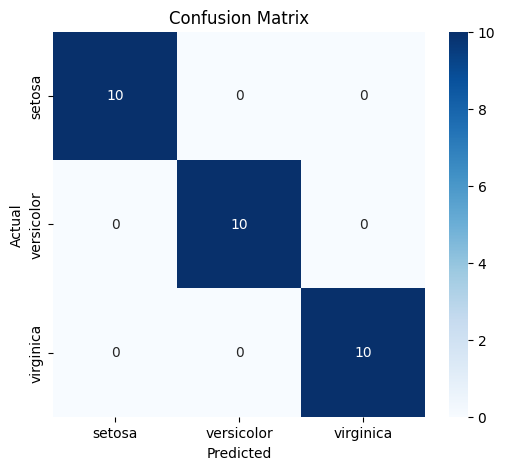

In [36]:
# Import the libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using heatmap the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=df.target_names, yticklabels=df.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()


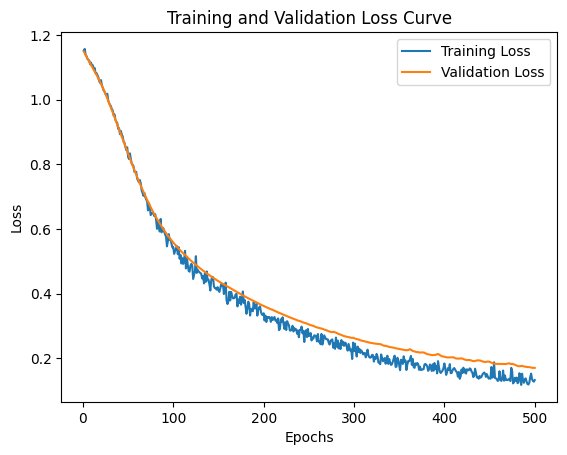

In [37]:
# Plotting the graph of train and validation loss after every epoch
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
wandb.log({"loss_curve": wandb.Image(plt)})
plt.show()

In [38]:
# Finish the wandb
wandb.finish()

Accuracy,▁
F1 score,▁
Precision,▁
Recall,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
train_loss,█▇▇▆▆▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▆▅▅▅▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Accuracy,1
F1 score,1
Precision,1
Recall,1


## Section 2

### Task 1

In [39]:
# Importing neccessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from itertools import product
from sklearn.model_selection import train_test_split
import pandas as pd

In [40]:
# Define a custom neural network model
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(4, 32)  # Hidden Layer
        self.fc2 = nn.Linear(32, 3)    # Output Layer

    def forward(self, x):
        # Activation function (ReLU)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [42]:
# Function to train and evaluate the model
def train_and_evaluate(x_train, y_train, x_val, y_val, x_test, y_test, batch_size, learning_rate, epochs):

    # Converting NumPy arrays to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Creating DataLoader for batch processing
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initializing model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training the model
    train_losses = []
    val_losses = []
    for epoch in range(1,epochs+1):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    # Evaluate the model on test
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predicted = torch.argmax(outputs, dim=1)  # Get class index
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(torch.argmax(y_batch, dim=1).cpu().numpy())
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    return acc, f1, y_true , y_pred, train_losses, val_losses

<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)



For bactch size = 2, learning rate = 0.001, epoches = 1
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


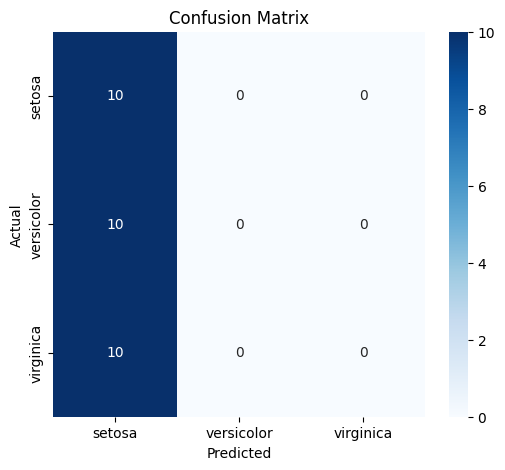

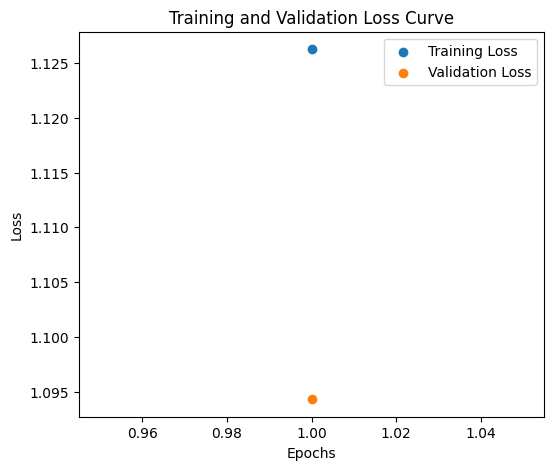


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 0
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 0
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 0
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 0

For bactch size = 2, learning rate = 0.001, epoches = 3
Accuracy =  0.7666666666666667
F1 score =  0.7340930674264008

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


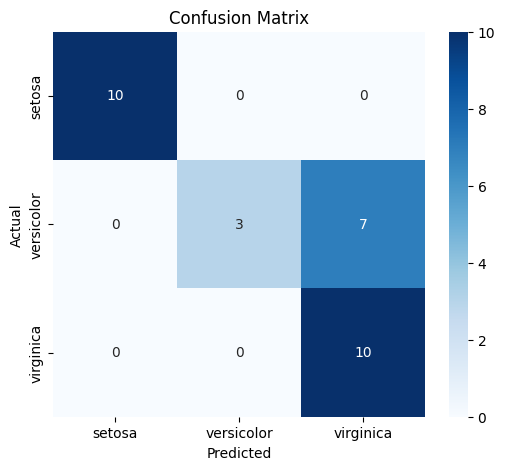

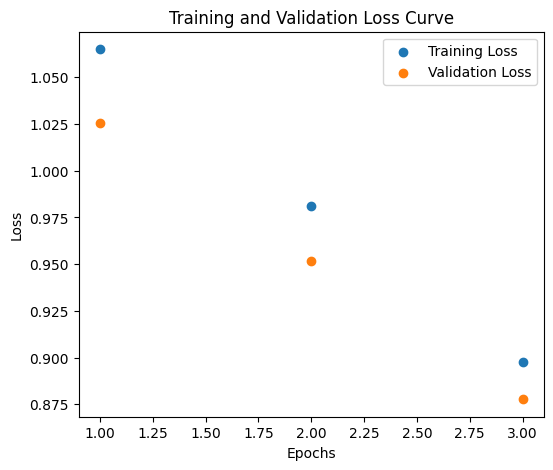


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 0
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)



For bactch size = 2, learning rate = 0.001, epoches = 5
Accuracy =  0.7333333333333333
F1 score =  0.6825396825396824

 Confusion Matrix


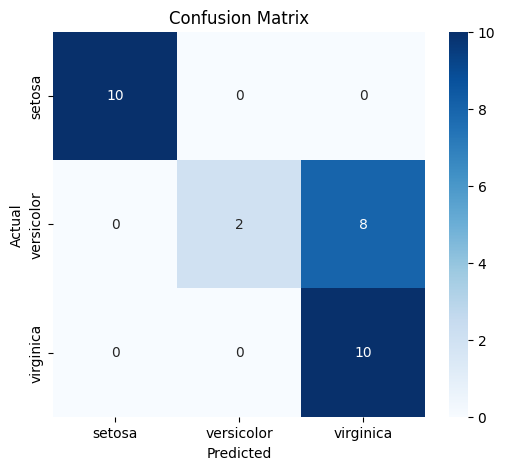

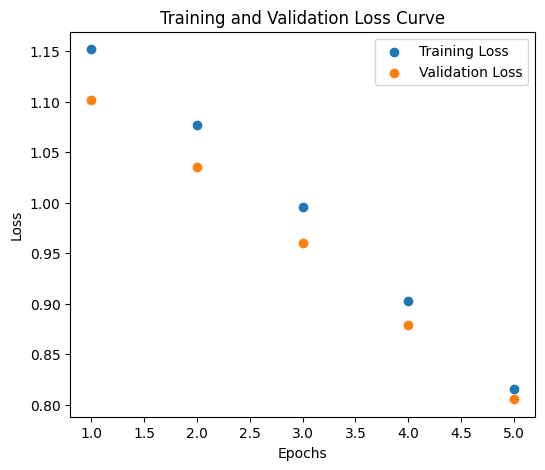


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 0
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 2, learning rate = 1e-05, epoches = 1
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


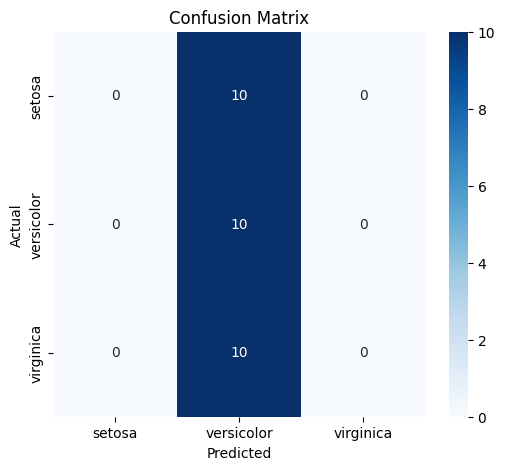

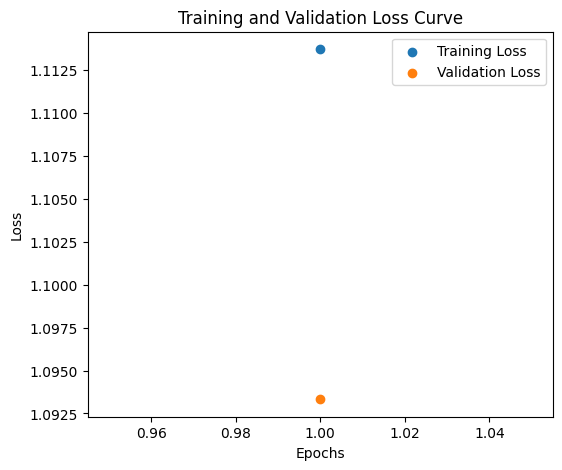


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 1
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 1
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 1
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 1

For bactch size = 2, learning rate = 1e-05, epoches = 3
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


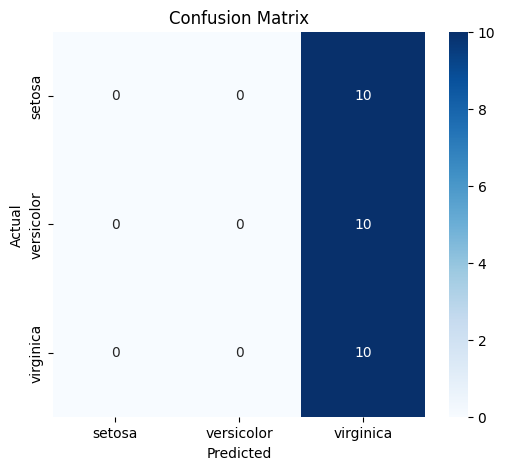

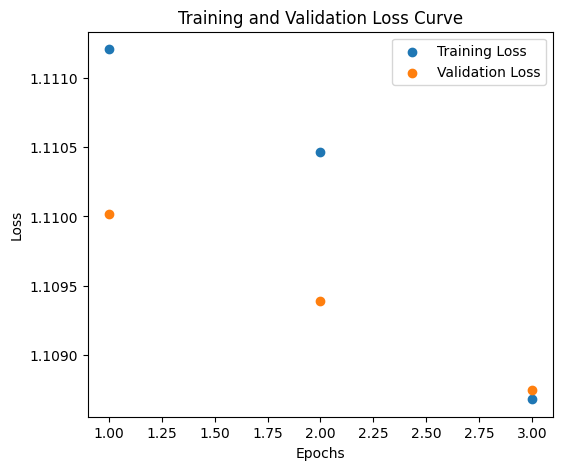


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 2
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 2, learning rate = 1e-05, epoches = 5
Accuracy =  0.4
F1 score =  0.4057644110275689

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


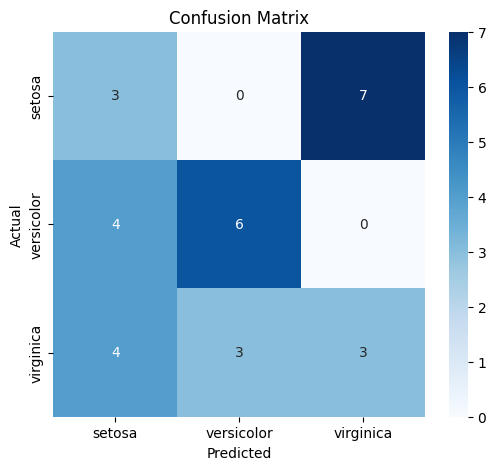

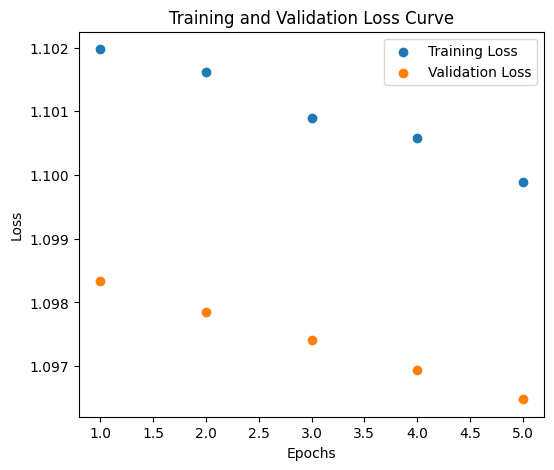


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 1
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 0

For bactch size = 4, learning rate = 0.001, epoches = 1
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


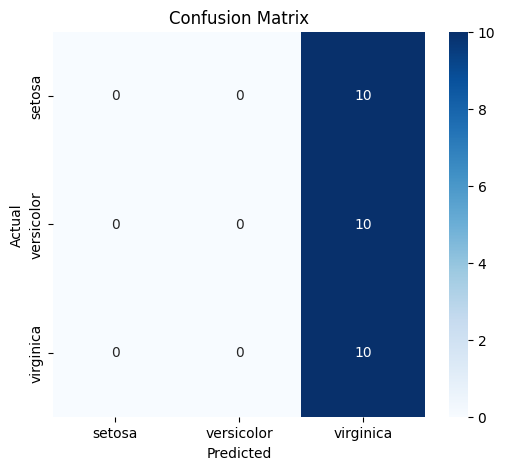

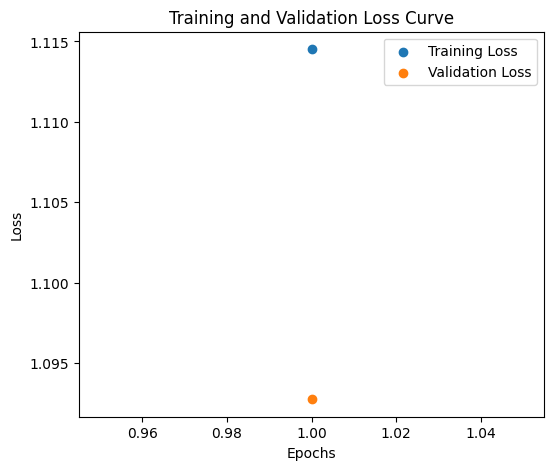


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 2
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 4, learning rate = 0.001, epoches = 3
Accuracy =  0.7333333333333333
F1 score =  0.702075702075702

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


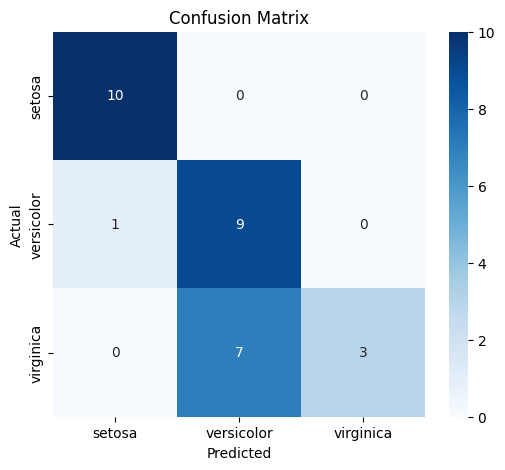

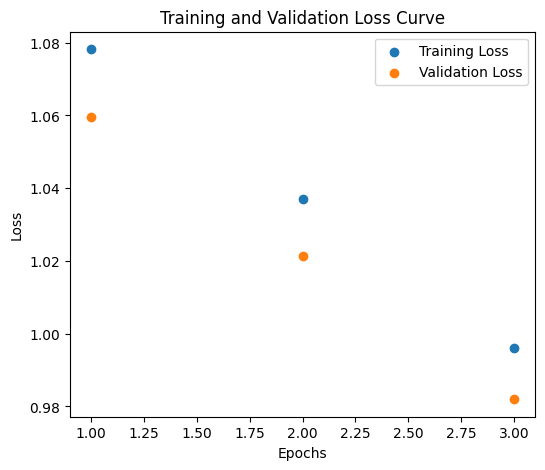


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 1
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 0
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 1

For bactch size = 4, learning rate = 0.001, epoches = 5
Accuracy =  0.6666666666666666
F1 score =  0.5555555555555555

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


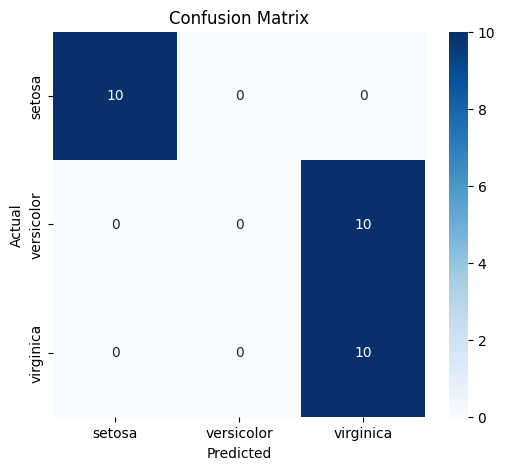

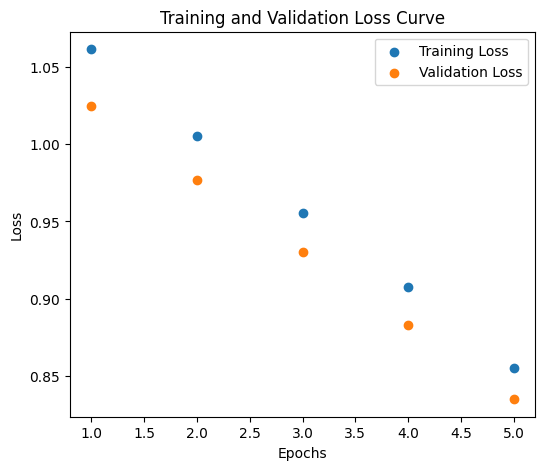


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 0
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 4, learning rate = 1e-05, epoches = 1
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


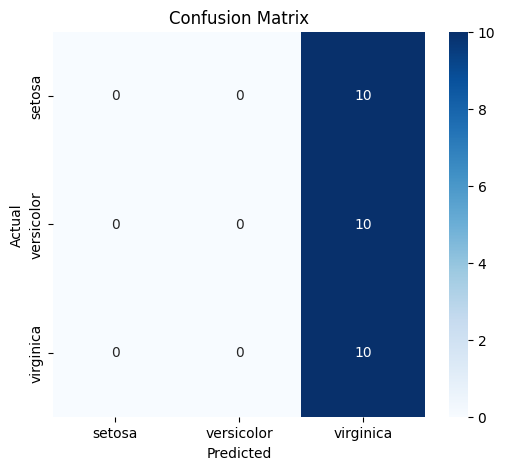

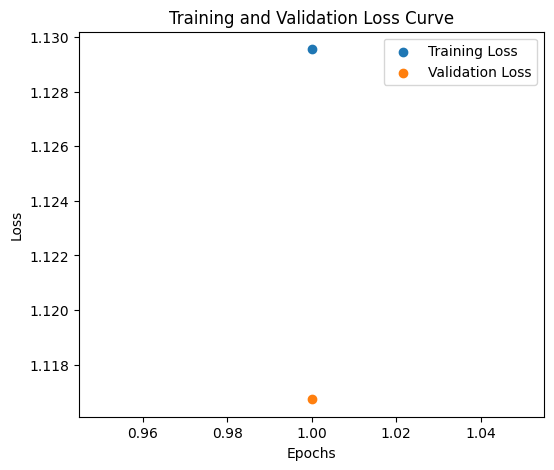


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 2
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 4, learning rate = 1e-05, epoches = 3
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


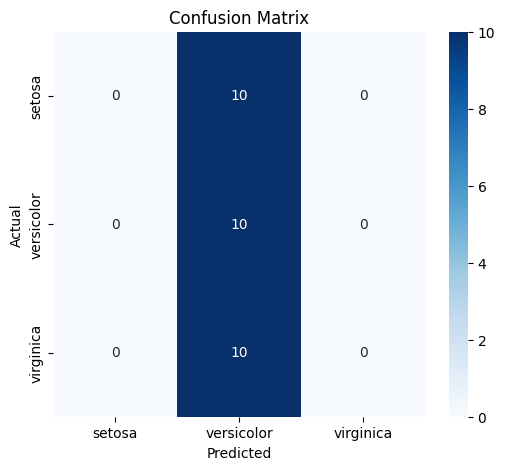

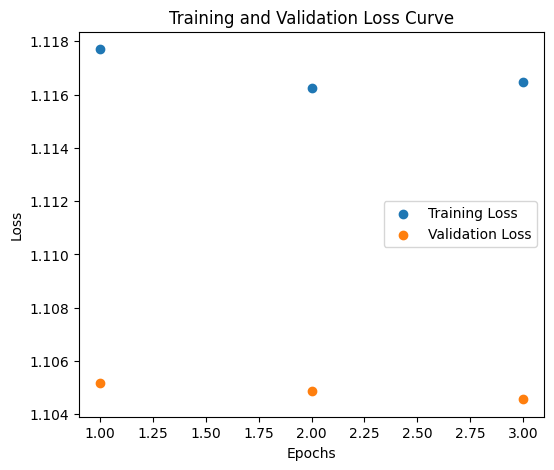


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 1
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 1
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 1
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 1

For bactch size = 4, learning rate = 1e-05, epoches = 5
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


<ipython-input-42-ee42219e894d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


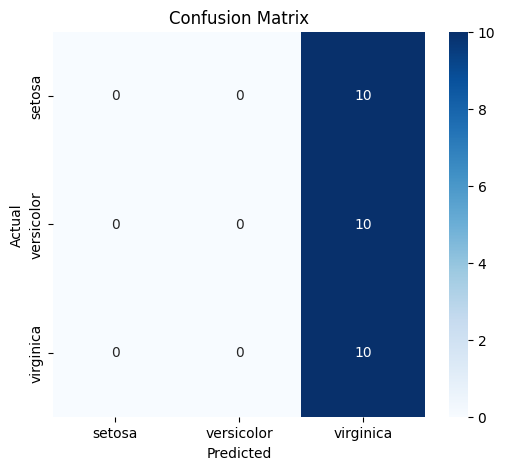

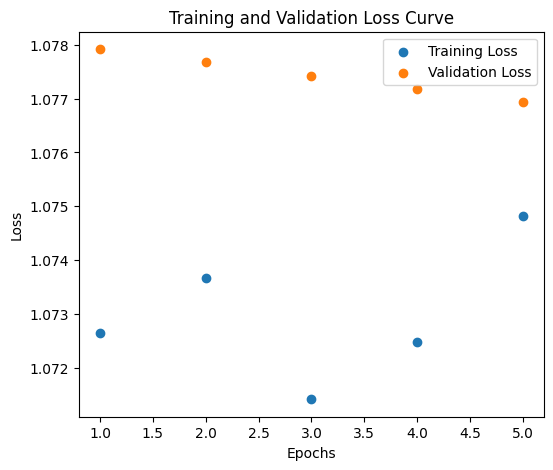


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 2
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

Hyperparameter Tuning Results:
    Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
0            2        0.00100       1  0.333333  0.166667
1            2        0.00100       3  0.766667  0.734093
2            2        0.00100       5  0.733333  0.682540
3            2        0.00001       1  0.333333  0.166667
4            2        0.00001       3  0.333333  0.166667
5            2        0.00001       5  0.400000  0.405764
6            4        0.00100       1  0.333333  0.166667
7            4        0.00100       3  0.733333  0.702076
8            4        0.00100      

In [75]:
# Hyperparameters to test
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

# Run experiments for every combination of hyperparameter
results = []
best_f1 = 0
best_acc = 0
best_hyperparams_f1 = {}
best_hyperparams_acc = {}

for batch_size, lr, epochs in product(batch_sizes, learning_rates, epochs_list):
    acc, f1, y_true, y_pred, train_losses, val_losses = train_and_evaluate(x_train_scaled, y_train, x_val_scaled, y_val, x_test_scaled, y_test, batch_size, lr, epochs)
    results.append([batch_size, lr, epochs, acc, f1])

    # Print metrics for every combination of hyperparameter
    print(f"\nFor bactch size = {batch_size}, learning rate = {lr}, epoches = {epochs}")
    print("Accuracy = ",acc)
    print("F1 score = ",f1)

    # Compute confusion matrix for every combination of hyperparameter
    print("\n Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=df.target_names, yticklabels=df.target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting the graph of train and validation loss for every combination of hyperparameter
    plt.figure(figsize=(6,5))
    plt.scatter(range(1, epochs+1), train_losses, label="Training Loss")
    plt.scatter(range(1, epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.show()

    # Show 5 sample predictions for every combination of hyperparameter
    print("\nSample Predictions:")
    for i in range(5):
        print(f"Input: {x_test_scaled[i]}, Truth: {y_true[i]}, Prediction: {y_pred[i]}")


    # Track best hyperparameters based on accuracy
    if acc > best_acc:
        best_acc = acc
        best_hyperparams_acc = {"Batch Size": batch_size, "Learning Rate": lr, "Epochs": epochs}

    # Track best hyperparameters based on f1 score
    if f1 > best_f1:
        best_f1 = f1
        best_hyperparams_f1 = {"Batch Size": batch_size, "Learning Rate": lr, "Epochs": epochs}

# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1 Score"])
print("\nHyperparameter Tuning Results:")
print(results_df)

# Display best hyperparameters based on Accuracy
print("\nBest Hyperparameters based on Accuracy:")
print(best_hyperparams_acc)

# Display best hyperparameters based on F1 Score
print("\nBest Hyperparameters based on F1 Score:")
print(best_hyperparams_f1)

From this we can observe that -
1. When the batch size is smaller then the accuracy is more.
2. When the learning rate is more then the accuracy is more.
3. When the number of epoches is more then the accuracy is higher.

Thus we can conclude that accuracy is inversely proportional to batch size and directy proportional to learing rate and number of epoches.

### Task 2

In [23]:
!pip install scikit-optimize ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 MB 12.9 MB/s eta 0:00:00


In [24]:
!pip install scikit-optimize

In [68]:
# Import the neccessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid, ParameterSampler
from skopt import gp_minimize
from skopt.space import Integer, Real

In [69]:
# Define search space
param_grid = {
    "batch_size": [2, 4],
    "lr": [1e-3, 1e-5],
    "epochs": [1, 3, 5]
}

In [70]:
# Placeholder function for training & evaluation
def train_and_evaluate_2(x_train, y_train, x_test, y_test, batch_size, learning_rate, epochs):

    # Converting NumPy arrays to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Converting it to dataloaders for batch processing
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Defing the model, loss function, optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training the model
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluting the model on test
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predicted = torch.argmax(outputs, dim=1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

    # Finding accuracy and f1 score
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    return acc, f1

In [71]:
# GRID SEARCH
grid_results = []
for params in ParameterGrid(param_grid):
    acc, f1 = train_and_evaluate_2(x_train_scaled, y_train, x_test_scaled, y_test, params["batch_size"], params["lr"], params["epochs"])
    grid_results.append((params["batch_size"], params["lr"], params["epochs"], acc, f1))

# Making a dataframe of it
grid_df = pd.DataFrame(grid_results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1 Score"])

In [72]:
# RANDOM SEARCH
random_results = []
for params in ParameterSampler(param_grid, n_iter=6, random_state=42):
    acc, f1 = train_and_evaluate_2(x_train_scaled, y_train, x_test_scaled, y_test, params["batch_size"], params["lr"], params["epochs"])
    random_results.append((params["batch_size"], params["lr"], params["epochs"], acc, f1))

# Making a dataframe of it
random_df = pd.DataFrame(random_results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1 Score"])

In [73]:
# BAYESIAN OPTIMIZATION
def objective(params):
    batch_size, lr, epochs = params
    batch_size = int(batch_size)  # Ensure it's an integer
    epochs = int(epochs)  # Ensure it's an integer

    acc, f1 = train_and_evaluate_2(x_train_scaled, y_train, x_test_scaled, y_test, batch_size, lr, epochs)
    return -f1  # Minimize negative F1-score

# Defing the search space for bayesian
search_space = [
    Integer(2, 4, name="batch_size"),
    Real(1e-5, 1e-3, name="lr"),
    Integer(1, 5, name="epochs")
]

# Minimizing the -f1 score
bayes_result = gp_minimize(objective, search_space, n_calls=12, random_state=42)

bayesian_results = [
    (x[0], x[1], x[2], acc, -y)  # Swap Accuracy and F1 Score order
    for x, y, acc in zip(
        bayes_result.x_iters,
        bayes_result.func_vals,
        [train_and_evaluate_2(x_train_scaled, y_train, x_test_scaled, y_test, int(x[0]), x[1], int(x[2]))[0] for x in bayes_result.x_iters]
    )
]

# Making a dataframe of it
bayesian_df = pd.DataFrame(bayesian_results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1 Score"])

In [74]:
# COMPARE RESULTS
print("\nGrid Search Results :")
print(grid_df)
print("Max Accuracy :",grid_df['Accuracy'].max())

print("\nRandom Search Results :")
print(random_df)
print("Max Accuracy :",random_df['Accuracy'].max())

print("\nBayesian Optimization Results :")
print(bayesian_df)
print("Max Accuracy :",bayesian_df['Accuracy'].max())

# Combine all results into one table
final_df = pd.concat([
    grid_df.assign(Method="Grid Search"),
    random_df.assign(Method="Random Search"),
    bayesian_df.assign(Method="Bayesian Optimization")
])

print("\nFinal Comparison :")
print(final_df)


Grid Search Results :
    Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
0            2        0.00100       1  0.333333  0.166667
1            2        0.00001       1  0.600000  0.493506
2            2        0.00100       3  0.666667  0.555556
3            2        0.00001       3  0.333333  0.208333
4            2        0.00100       5  0.666667  0.555556
5            2        0.00001       5  0.266667  0.177778
6            4        0.00100       1  0.166667  0.095238
7            4        0.00001       1  0.333333  0.222222
8            4        0.00100       3  0.333333  0.190476
9            4        0.00001       3  0.633333  0.530843
10           4        0.00100       5  0.700000  0.623824
11           4        0.00001       5  0.333333  0.222222
Max Accuracy : 0.7

Random Search Results :
   Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
0           4        0.00100       5  0.700000  0.623824
1           4        0.00001       3  0.266667  0.140351
2       

All have the max accuracy something similar but...

On the basis of the above maximum we can say that bayesian is  giving the best accuracy.

And the random and grid are also giving good results.